In [1]:
import sys
sys.path.append("/home/q621464/Desktop/Thesis/code/decision-transformer-thesis")
sys.path.append("/home/q621464/Desktop/Thesis/code/decision-transformer-thesis/atari")

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
import csv
import logging
# make deterministic
from atari.mingpt.utils import set_seed
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from torch.utils.data import Dataset
from atari.mingpt.model_atari import GPT, GPTConfig
from atari.mingpt.trainer_atari import Trainer, TrainerConfig
from atari.mingpt.utils import sample
from collections import deque
import random
import torch
import pickle
import blosc
import argparse
from atari.create_dataset import create_dataset
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Apply dimensionality reduction here
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

2023-08-01 11:26:47.779176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 11:26:47.887639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/q621464/miniconda3/envs/decision-transformer-atari/lib/python3.7/site-packages/cv2/../../lib64::/home/q621464/.mujoco/mujoco200/bin
2023-08-01 11:26:47.887655: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-01 11:26:48.376257: W tensorflow/compiler/xla/stream_executor/platform/default/d

In [4]:
# set up logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [5]:
class Config():
    def __init__(self, seed=123, context_length=30, epochs=5, model_type='reward_conditioned', num_steps=500000, num_buffers=50, env='SmartClimate', batch_size=128, log_to_wandb=False, trajectories_per_buffer=10, train_data_dir='../atari/data-for-dt/smart-climate-train-trajectories-v2.pkl', val_data_dir='../atari/data-for-dt/smart-climate-val-trajectories-v2.pkl', test_data_dir='../atari/data-for-dt/smart-climate-test-trajectories-v2.pkl') -> None:
        self.seed = seed
        self.context_length = context_length
        self.epochs = epochs
        self.model_type = model_type
        self.num_steps =num_steps
        self.num_buffers = num_buffers
        self.env = env
        self.batch_size = batch_size
        self.log_to_wandb = log_to_wandb
        self.trajectories_per_buffer = trajectories_per_buffer
        self.train_data_dir = train_data_dir
        self.val_data_dir = val_data_dir
        self.test_data_dir = test_data_dir
        self.dim_reductor = None

In [6]:
args = Config(env='SmartClimate', epochs=30, seed=123, context_length=20, train_data_dir='../atari/data-for-dt/smart-climate-train-trajectories-v2.pkl')
set_seed(args.seed)

In [7]:
def reduce_dimensionality(obss):
    X_train = obss
    # Data normalizationd
    scaler = StandardScaler()
    # Fit and transform the data to perform z-score normalization
    X_train_normalized = scaler.fit_transform(X_train)

    # Initialize PCA with the desired number of components (e.g., None for all components)
    pca = PCA(n_components=None)

    # Fit and transform the training data using PCA
    X_train_pca = pca.fit_transform(X_train_normalized)

    # Get the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # Get the cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Set a threshold for the cumulative explained variance ratio (e.g., 95% or 99%)
    threshold_variance = 0.85

    # Determine the number of components required to achieve the threshold
    n_components = np.argmax(cumulative_variance_ratio >= threshold_variance) + 1
    print(f"Number of selected components: {n_components}")

    # Reduce the dimensionality to the selected number of components
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_normalized)
    print(f"Shape of the reeduced dimensionality dataset: {X_train_pca.shape}")

    obss_reduced = X_train_pca
    return obss_reduced, pca
    # X_test_pca = pca.transform(X_test)

In [8]:
def create_dataset(data_dir, total_trajectories=8000):
    with open(data_dir, 'rb') as f:
        trajectories = pickle.load(f)[0:total_trajectories]
    obss = []
    actions = []
    returns = [0]
    done_idxs = []
    stepwise_returns = []    
    for traj in trajectories:
        obss += traj['observations'].tolist()
        actions += traj['actions'].tolist()
        stepwise_returns += traj['rewards'].tolist()
        done_idxs += [len(obss)]
        returns += [0]

    actions = np.array(actions)
    returns = np.array(returns)
    stepwise_returns = np.array(stepwise_returns)
    done_idxs = np.array(done_idxs)

    # -- create reward-to-go dataset
    start_index = 0
    rtg = np.zeros_like(stepwise_returns)
    for i in done_idxs:
        i = int(i)
        curr_traj_returns = stepwise_returns[start_index:i]
        for j in range(i-1, start_index-1, -1): # start from i-1
            rtg_j = curr_traj_returns[j-start_index:i-start_index]
            rtg[j] = sum(rtg_j)
        start_index = i
    print('max rtg is %d' % max(rtg))

    # -- create timestep dataset
    start_index = 0
    timesteps = np.zeros(len(actions)+1, dtype=int)
    print(f"total done idx: {len(done_idxs)}")
    for i in done_idxs:
        # print(f"done_idx: {i}")
        i = int(i)
        # print(f"start_idx: {start_index}, i: {i}")
        timesteps[start_index:i+1] = np.arange(i+1 - start_index)
        start_index = i+1
    print('max timestep is %d' % max(timesteps))
    
    # if apply_dim_reduction:
    #     obss, dim_reductor = reduce_dimensionality(obss)
    return obss, actions, returns, done_idxs, rtg, timesteps

In [9]:
class StateActionReturnDataset(Dataset):

    def __init__(self, data, block_size, actions, done_idxs, rtgs, timesteps, mean=0, std=1):
        self.block_size = block_size
        self.vocab_size = max(actions) + 1 # TODO: needs to be changed. Does it change dynamically based on the sampled data?
        self.data = data
        self.actions = actions
        self.done_idxs = done_idxs
        self.rtgs = rtgs
        self.timesteps = timesteps
        self.mean = mean
        self.std = std
    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # print(f"Sampled idx: {idx}")
        block_size = self.block_size // 3
        states = torch.tensor(np.array(self.data[idx:idx+block_size]), dtype=torch.float32).reshape(block_size, -1) # 
        # (block_size, 4*84*84)
        
        # print(f"There are nan values in the dataloader's batch: {torch.isnan(states).any()}")
        # mean = torch.mean(states)
        # std = torch.std(states)
        # states = (states - self.mean) / self.std
        # print(f"mean: {mean}, std: {std} of the batch\n")
        # states = states / 255.
        # print(f"There are nan values in the dataloader's batch after normalization: {torch.isnan(states).any()}")
        actions = torch.tensor(self.actions[idx:idx+block_size], dtype=torch.long).unsqueeze(1) # (block_size, 1)
        rtgs = torch.tensor(self.rtgs[idx:idx+block_size], dtype=torch.float32).unsqueeze(1)
        timesteps = torch.tensor(self.timesteps[idx:idx+1], dtype=torch.int64).unsqueeze(1)
        # print(f"timesteps shape: {timesteps.shape}")

        return states, actions, rtgs, timesteps

In [24]:
# Create the train dataset first
obss, actions, returns, done_idxs, rtgs, timesteps = create_dataset(args.train_data_dir, total_trajectories=800)

# Create the validation dataset
obss_val, actions_val, returns_val, done_idxs_val, rtgs_val, timesteps_val = create_dataset(args.val_data_dir, total_trajectories=100)

# Sanity check
# Are there any nan values in the obss
print(f"There are nan values in the obss: {np.isnan(np.array(obss)).any()}")

print("*" * len(args.env + "Environment"))
print(f"{args.env} Environment")
print("*" * len(args.env + "Environment"))
print(f"total obss: {len(obss)}\ntotal actions: {actions.shape}\ntotal returns: {returns.shape}\ntimesteps: {len(timesteps)}")

max rtg is 0
total done idx: 800
max timestep is 46
max rtg is 0
total done idx: 100
max timestep is 36
There are nan values in the obss: False
***********************
SmartClimate Environment
***********************
total obss: 13263
total actions: (13263,)
total returns: (801,)
timesteps: 13264


In [11]:
# obss, dim_reductor = reduce_dimensionality(obss)
# obss_val = dim_reductor.transform(obss_val)

##### Best hyperparameters from hyperparameter tuning: 
1. Aimed at minimizing val_loss: {'learning_rate': 0.00019714606731026987, 'num_hidden_units': 40, 'context_length': 20, 'n_layer': 4}
2. Aimed at increasing val_accuracy: {'learning_rate': 0.0003999625589556598, 'num_hidden_units': 208, 'context_length': 10, 'n_layer': 8}

### Feature Selection

In [12]:
# First load the Smart Climate Curated Dataset
climate_data_2021 = pd.read_csv("../data/smart_climate_curated.csv")
climate_data_2021.drop(['d_drive_uid', 'c_msg_creation_timestamp', 'c_drive_timestamp_start', 'c_target_temp'], axis=1, inplace=True)
climate_data_2021.shape

(128257, 324)

In [13]:
climate_data_2021.head()

,c_min_exteriortemperature_celsius,c_exteriortemperature_avg_celsius,c_max_exteriortemperature_celsius,c_drive_duration_sec,c_weekend_drive,c_mean_speed,c_is_active_profile,c_is_guest_profile,c_touchscreen_used,c_touchscreen_used_count,...,c_vehicle_class_KKL+,c_vehicle_class_MKL+,c_vehicle_class_UKL2+,c_script_version_MGUV5,c_script_version_MGUV6,c_script_version_MGUV7,c_gcad_ACTIVE_PROFILE,c_gcad_GUEST_PROFILE,c_gcad_NOT VALID GCAD,c_gcad_NOT_AVAILABLE
0,23.0,24.25,25.5,4692,0,19.65,1,0,1,18,...,1,0,0,0,1,0,1,0,0,0
1,23.0,24.25,25.5,4692,0,19.65,1,0,1,18,...,1,0,0,0,1,0,1,0,0,0
2,23.0,24.25,25.5,4692,0,19.65,1,0,1,18,...,1,0,0,0,1,0,1,0,0,0
3,23.0,24.25,25.5,4692,0,19.65,1,0,1,18,...,1,0,0,0,1,0,1,0,0,0
4,23.0,24.25,25.5,4692,0,19.65,1,0,1,18,...,1,0,0,0,1,0,1,0,0,0


In [14]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif

# selector = SelectKBest(f_classif, k=10)
# selected_features = selector.fit_transform(X, y)

In [15]:
from sklearn.utils import Bunch
def load_data(obss, actions):
    data = {
        'data': obss,
        'target': actions,
        'feature_names': climate_data_2021.columns.tolist(),
        'target_names': [str(target) for target in np.arange(16.0, 28.5, 0.5)]
    }
    dataset_bunch = Bunch(**data)
    return dataset_bunch

#### F-score calculation for feature selection

/home/q621464/miniconda3/envs/decision-transformer-atari/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 66  70  81  82  86  88  90  91  92  96  97  98  99 104 105 106 107 110
 115 120 124 132 133 137 138 145 146 147 149 152 153 154 155 156 157 158
 159 160 161 162 164 165 170 172 174 175 176 177 180 183 184 186 187 188
 189 192 193 194 195 198 200 201 205 210 211 212 213 214 215 217 218 219
 220 221 222 224 226 227 228 229 232 233 234 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 255 256 258 259 260 261 263
 264 265 268 271 274 275 276 277 279 280 281 282 284 288 290 291 299 307
 308] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/q621464/miniconda3/envs/decision-transformer-atari/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


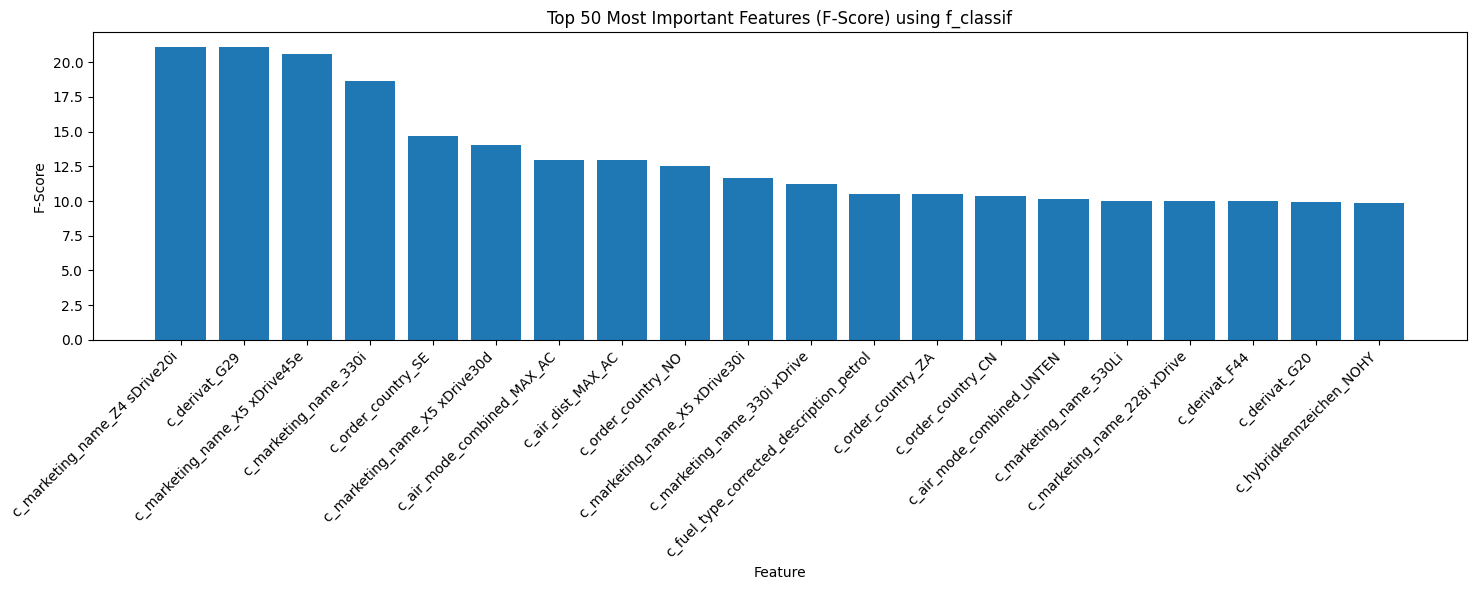

In [16]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# # from sklearn.datasets import load_iris
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# # Load the iris dataset as an example
# data = load_data(obss_val, actions_val)
# X, y = data.data, data.target
# feature_names = data.feature_names

# # Split the data
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=123)
# scaler = MinMaxScaler()
# X_train_normalized = scaler.fit_transform(X_train)
# # Calculate F-scores and p-values using f_classif
# f_scores, p_values = f_classif(X_train_normalized, y_train)

# # Create a DataFrame to store the results
# results_df = pd.DataFrame({'Feature': feature_names, 'F-Score': f_scores, 'P-Value': p_values})

# # Sort the DataFrame by F-Score in descending order
# results_df.sort_values(by='F-Score', ascending=False, inplace=True)

# # Take the top 50 features
# top_features_df = results_df.head(20)

# # Plot the top 50 features based on F-Score using a bar plot
# plt.figure(figsize=(15, 6))
# plt.bar(top_features_df['Feature'], top_features_df['F-Score'])
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Feature')
# plt.ylabel('F-Score')
# plt.title('Top 50 Most Important Features (F-Score) using f_classif')
# plt.tight_layout()
# plt.show()


#### RFE

In [17]:
import numpy as np
import pandas as pd
# from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# Load the iris dataset as an example
data = load_data(obss_val, actions_val)
X, y = data.data, data.target
feature_names = data.feature_names

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=123)
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
# Create a Random Forest classifier as the estimator
estimator = RandomForestClassifier(n_estimators=100, random_state=123)

# Specify the number of features you want to keep after feature selection
num_features_to_keep = 20

# RFE feature selection
rfe = RFE(estimator=estimator, n_features_to_select=num_features_to_keep)
X_train_selected = rfe.fit_transform(X_train_normalized, y_train)
X_val_selected = rfe.transform(X_val_normalized)

# Get the support (mask) of selected features
selected_feature_indices = rfe.support_

# Get the names of the selected features
selected_feature_names = [feature_names[i] for i in np.where(selected_feature_indices)[0]]

# Print the names of the selected features
print("Selected Features:")
print(selected_feature_names)

Selected Features:
['c_min_exteriortemperature_celsius', 'c_exteriortemperature_avg_celsius', 'c_max_exteriortemperature_celsius', 'c_drive_duration_sec', 'c_weekend_drive', 'c_mean_speed', 'c_touchscreen_used_count', 'c_air_mode_combined_OFF', 'c_blower_level_BL_1', 'c_blower_level_BL_2', 'c_blower_level_BL_3', 'c_blower_level_Off', 'c_blower_style_KS_1', 'c_air_dist_MITTE', 'c_auto_mode_AUTO_ON', 'c_pwf_FAHREN', 'c_pwf_WOHNEN', 'c_pwf_group_WOHNEN', 'c_fuel_type_corrected_description_petrol', 'c_vehicle_class_KKL+']


In [18]:
top_features_f_classif = set(top_features_df['Feature'].tolist())
top_features_rfe = set(selected_feature_names)

In [19]:
len(top_features_f_classif.intersection(top_features_rfe))

1

In [21]:
# Load the test data
obss_test, actions_test, returns_test, done_idxs_test, rtgs_test, timesteps_test = create_dataset(args.test_data_dir, total_trajectories=2000)
len(obss_test), len(actions_test)

X_test, y_test = obss_test, actions_test
X_test_normalized = scaler.transform(X_test)
X_test_selected = rfe.transform(X_test_normalized)

In [22]:
# Test on the whole test data using RF

# Step 3: Train a model using the selected features on the training set
model = RandomForestClassifier(n_estimators=100, random_state=123)
model.fit(X_test_selected, y_test)

# Step 4: Test the model's performance on the testing set using the selected features
y_pred = model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.74


In [40]:
from sklearn.neural_network import MLPClassifier
# Train with MLP
# Step 3: Create the two-layer MLP model

X_train, y_train = obss, actions
print(len(X_train), len(y_train))
# X_train_normalized = scaler.fit_transform(X_train)
# X_train_selected = rfe.fit_transform(X_train_normalized, y_train)

X_train = np.array(X_train)
# print(X_train.shape)

print(X_train.shape)
state_mean, state_std = np.mean(X_train, axis=0), np.std(X_train, axis=0) + 1e-6
# X_test_selected = X_test_selected
X_train = (X_train - state_mean)/state_std

learning_rate = 0.0001
batch_size = 32
model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='tanh', solver='adam',
                      learning_rate_init=learning_rate, batch_size=batch_size, random_state=123, max_iter=200)

# Step 4: Train the model on the training set
model.fit(X_train, y_train)


X_test = (np.array(X_test) - state_mean) / state_std
# Step 5: Predict labels on the testing set
y_pred = model.predict(X_test_selected)

# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

13263 13263
(13263, 324)
(4297212,)


ValueError: Expected 2D array, got 1D array instead:
array=[ 8.5 12.5 16.5 ...  0.   1.   0. ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# # Doing some grid search
# # Step 3: Create the MLP model
# from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# from scipy.stats import randint, uniform
# mlp = MLPClassifier(random_state=42)

# # Step 4: Define hyperparameters and their search space
# param_distributions = {
#     'hidden_layer_sizes': [(64, 64), (128, 128), (256, 256)],
#     'activation': ['relu', 'tanh'],
#     'solver': ['adam', 'sgd'],
#     'learning_rate_init': uniform(0.0001, 0.01),
#     'max_iter': randint(100, 500),
#     'batch_size': [2**i for i in range(4, 8)]
# }

# # Step 5: Perform randomized search with cross-validation to find the best hyperparameters
# randomized_search = RandomizedSearchCV(mlp, param_distributions, n_iter=100, cv=3, n_jobs=-1, verbose=2,  refit='accuracy')
# randomized_search.fit(X_train_normalized, y_train)

# # Step 6: Get the best hyperparameters and evaluate the model
# best_params = randomized_search.best_params_
# print("Best Hyperparameters:", best_params)

# best_model = randomized_search.best_estimator_
# y_pred = best_model.predict(X_test_normalized)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# # Step 3: Train a model using the selected features on the training set
# model = RandomForestClassifier(n_estimators=100, random_state=123)
# model.fit(X_train_selected, y_train)

# # Step 4: Test the model's performance on the testing set using the selected features
# y_pred = model.predict(X_val_selected)
# accuracy = accuracy_score(y_val, y_pred)

# print(f"Val Accuracy: {accuracy:.2f}")

In [ ]:
from sklearn.metrics import f1_score
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Calculate the micro F1 score
micro_f1 = f1_score(y_test, y_pred, average='micro')

print("Macro F1 Score:", macro_f1)
print("Micro F1 Score:", micro_f1)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
# Calculate and display the classification report for each class
class_names = data.target_names
report = classification_report(y_test, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

In [ ]:
classes = np.arange(16, 28.5, 0.5)
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

for target, prediction in zip(y_val, y_pred):
    if target == prediction:
        correct_pred[target] += 1
    total_pred[target] += 1
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] > 0:
        accuracy = 100 * float(correct_count) / total_pred[classname]
    else:
        accuracy = 0
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

### Results investigation

In [ ]:
plt.plot(epoch_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f"train and val loss for {len(train_dataset)} train and {len(val_dataset)} datapoints")
# plt.show()
plt.savefig(f'Figures/train_and_val_loss_for_{len(train_dataset)}_datapoints.jpg')

In [ ]:
from atari.mingpt.envs.smart_climate_env import CustomActionSpace
action_map = CustomActionSpace().actions_map

train_actions_str = [str(action_map[action]) for action in actions]
predicted_actions_str = [str(action) for action in predicted_actions]
target_actions_str = [str(action) for action in target_actions]

In [ ]:
train_actions_unique, counts = np.unique(train_actions_str, return_counts=True)
train_action_count_dict = dict(zip(train_actions_unique, counts))

target_actions_unique, counts = np.unique(target_actions_str, return_counts=True)
target_action_count_dict = dict(zip(target_actions_unique, counts))

predicted_actions_unique, counts = np.unique(predicted_actions_str, return_counts=True)
predicted_action_count_dict = dict(zip(predicted_actions_unique, counts))

for action in np.arange(16.0, 28.5, 0.5):
    if str(action) not in predicted_action_count_dict.keys():
        predicted_action_count_dict[str(action)] = 0
    if str(action) not in train_action_count_dict.keys():
        train_action_count_dict[str(action)] = 0
    if str(action) not in target_action_count_dict.keys():
        target_action_count_dict[str(action)] = 0

sorted_keys = sorted(predicted_action_count_dict)
predicted_action_count_dict = {key: predicted_action_count_dict[key] for key in sorted_keys}
train_action_count_dict = {key: train_action_count_dict[key] for key in sorted_keys}
target_action_count_dict = {key: target_action_count_dict[key] for key in sorted_keys}

sorted(train_action_count_dict.keys()) == sorted(predicted_action_count_dict.keys())

In [ ]:
accuracy = accuracy_score(target_actions_str, predicted_actions_str)
print(f"Evaluation Accuracy: {accuracy * 100:.4f}")

In [ ]:
from sklearn.metrics import f1_score
macro_f1 = f1_score(target_actions_str, predicted_actions_str, average='macro')

# Calculate the micro F1 score
micro_f1 = f1_score(target_actions_str, predicted_actions_str, average='micro')

print("Macro F1 Score:", macro_f1)
print("Micro F1 Score:", micro_f1)

In [ ]:
classes = np.arange(16, 28.5, 0.5)
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

for target, prediction in zip(target_actions, predicted_actions):
    if target == prediction:
        correct_pred[target] += 1
    total_pred[target] += 1
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] > 0:
        accuracy = 100 * float(correct_count) / total_pred[classname]
    else:
        accuracy = 0
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

In [ ]:
# Sample data for three datasets
data1 = train_action_count_dict.values()
data2 = target_action_count_dict.values()
data3 = predicted_action_count_dict.values()

# Define the x-axis labels for the bars
x_labels = train_action_count_dict.keys()

# Create a figure and three subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot the bar plots on each subplot
bar_width = 1
x = np.arange(len(x_labels))

# Bar plot for Dataset 1
axes[0].bar(x, data1, bar_width, color='blue', label='train actions', edgecolor='black', alpha=0.5)
axes[0].set_xticks(x)
axes[0].set_xticklabels(x_labels, rotation=90)
axes[0].set_title('Target temperature from train dataset')

# Bar plot for Dataset 2
axes[1].bar(x, data2, bar_width, color='green', label='target actions', edgecolor='black', alpha=0.5)
axes[1].set_xticks(x)
axes[1].set_xticklabels(x_labels, rotation=90)
axes[1].set_title('Target temperature from evaluation set')

# Bar plot for Dataset 3
axes[2].bar(x, data3, bar_width, color='red', label='predicted actions', edgecolor='black', alpha=0.5)
axes[2].set_xticks(x)
axes[2].set_xticklabels(x_labels, rotation=90)
axes[2].set_title('Target temperature from the predictions')

# Add labels and title to the overall figure
plt.suptitle('Bar Plots of Train, Eval and Predicted target temperatures')
plt.tight_layout()
plt.show()


In [ ]:
# Build confusion matrix
unique_labels = np.unique(np.concatenate((target_actions_str, predicted_actions_str)))

# Build confusion matrix
cf_matrix = confusion_matrix(target_actions_str, predicted_actions_str, labels=unique_labels)

# Create a DataFrame from the confusion matrix for better visualization
df_cm = pd.DataFrame(cf_matrix, index=unique_labels, columns=unique_labels)

plt.figure(figsize = (16,16))
# plt.plot(df_cm)
sn.heatmap(df_cm, annot=True, cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion matrix for {len(train_dataset)} train and {len(predicted_actions)} datapoints")
# plt.show()
plt.savefig(f'Figures/Confusion matrix for {len(train_dataset)} train and {len(predicted_actions)} datapoints.jpg')


In [ ]:
sns.lineplot(returns)

In [ ]:
sns.histplot(sorted(train_actions_str))
plt.xlabel('Target Temperatures')
plt.title("Target Temperature distribution in the training set")
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.histplot(sorted(target_actions_str))
plt.xlabel('Target temperature')
plt.title("Target temperatures distribution in the evaluation set")
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.histplot(sorted(predicted_actions_str))
plt.xlabel('Target temperatures from the evaluation set')
plt.title("Predicted target temperatures distribution from the evaluation set")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# # Numbers of pairs of bars you want
# # N = 4

# # Data on X-axis

# # Specify the values of blue bars (height)
# # train_actions = list(train_action_count_dict.values())
# target_actions = list(target_action_count_dict.values())


# # Specify the values of orange bars (height)
# pred_actions = list(predicted_action_count_dict.values())


# print(len(target_actions), len(pred_actions))
# # Position of bars on x-axis
# ind = np.arange(16.0, 28.5, 0.5)
# # ind = np.arange(5)
# # print(ind)

# # Figure size
# plt.figure(figsize=(10,5))

# # Width of a bar 
# width = 0.2       

# # Plotting
# plt.bar(ind, target_actions , width, label='target action')
# plt.bar(ind + width, pred_actions, width, label='pred action')

# plt.xlabel('Actions')
# plt.ylabel('Count')
# plt.title('Action distribution comparison between target and predictions')

# # # xticks()
# # # First argument - A list of positions at which ticks should be placed
# # # Second argument -  A list of labels to place at the given locations
# # plt.xticks(ind+0.1, train_action_count_dict.keys())
# plt.xticks(ind+0.1, ind)

# # Finding the best position for legends and putting it
# plt.legend(loc='best')
# plt.xticks(rotation=90)
# plt.show()

### Hyperparameter Tuning

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
# from your_pytorch_model import YourModel  # Import your PyTorch model

def objective(trial):
    # Sample hyperparameters to be tuned by Optuna
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    num_hidden_units = trial.suggest_int('num_hidden_units', 32, 256)
    
    # Load the val_dataset
    val_data_dir = "../atari/data-for-dt/smart-climate-val-trajectories-v2.pkl"
    # Create the dataset first
    obss, actions, returns, done_idxs, rtgs, timesteps = create_dataset(val_data_dir, total_trajectories=8000, apply_dim_reduction=True)
    
    # Split your data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(obss, actions, test_size=0.1, random_state=123)
    
    val_dataset = StateActionReturnDataset(X_train, args.context_length*3, y_train, done_idxs, rtgs, timesteps)
    print(f"vocab size: {val_dataset.vocab_size}")
    
    # Define the model here
    mconf = GPTConfig(val_dataset.vocab_size, val_dataset.block_size, n_layer=6, n_head=8, n_embd=128, model_type=args.model_type, max_timestep=max(timesteps), input_dim=len(obss[0]))
    model = GPT(mconf)

    # Train the model for a fixed number of epochs
    epochs = 10
    tconf = TrainerConfig(max_epochs=epochs, batch_size=args.batch_size, learning_rate=6e-4, lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*args.context_length*3, num_workers=4, seed=args.seed, model_type=args.model_type, env=args.env, max_timestep=max(timesteps))
    
    rtg = 100
    max_ep_len = 100
    trainer = Trainer(model, train_dataset, None, tconf, args.env, rtg=rtg, max_ep_len=max_ep_len, num_eval_episodes=1)
    
    trainer.train()
    val_loss, val_accuracy = trainer.evaluate_model()

    # Return the validation loss as the objective value to be minimized
    return val_loss


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [ ]:
best_params = study.best_params
learning_rate = best_params['learning_rate']
num_hidden_units = best_params['num_hidden_units']
learning_rate, num_hidden_units
# # Train your final model using the best hyperparameters
# final_model = model(num_hidden_units)
# optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)

# Train the model on the entire training data
# ...


In [ ]:
# Load the val_dataset
val_data_dir = "../atari/data-for-dt/smart-climate-val-trajectories-v2.pkl"
# Create the dataset first
obss, actions, returns, done_idxs, rtgs, timesteps = create_dataset(val_data_dir, total_trajectories=8000, apply_dim_reduction=True)
# Sanity check
# Are there any nan values in the obss
print(f"There are nan values in the obss: {np.isnan(np.array(obss)).any()}")
print("*" * len(args.env + "Environment"))
print(f"{args.env} Environment")
print("*" * len(args.env + "Environment"))
print(f"total obss: {len(obss)}\ntotal actions: {actions.shape}\ntotal returns: {returns.shape}\ntimesteps: {len(timesteps)}")

In [ ]:
val_dataset = StateActionReturnDataset(obss, args.context_length*3, actions, done_idxs, rtgs, timesteps)
print(f"vocab size: {train_dataset.vocab_size}")

In [ ]:
# initialize a trainer instance and kick off training
epochs = 10
tconf = TrainerConfig(max_epochs=epochs, batch_size=args.batch_size, learning_rate=6e-4, lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*args.context_length*3, num_workers=4, seed=args.seed, model_type=args.model_type, env=args.env, max_timestep=max(timesteps))

In [ ]:
rtg = 100
max_ep_len = 100
trainer = Trainer(model, train_dataset, None, tconf, args.env, rtg=rtg, max_ep_len=max_ep_len, num_eval_episodes=1)
# avg_return, predicted_actions, target_actions, epoch_losses = trainer.train()
# print(f"Average reward achieved: {avg_return:.2f} with RTG: {rtg}")